In [1]:
import numpy as np
import scipy as sc
# la funcionalidad específica de robótica está en el toolbox
import roboticstoolbox as rtb
# spatialmath tiene define los grupos de transformaciones especiales: rotación SO3 y eculideo SE3
import spatialmath as sm
import spatialmath.base.symbolic as sym
import matplotlib.pyplot as plt  
from scipy.optimize import fsolve

In [12]:
# Esto fue un papelón. Ahora voy a sumarle el calculo del PCI analítico
class irb140_clase(rtb.DHRobot):
    def __init__(self, *args, **kwargs):
        super().__init__([
        rtb.RevoluteDH(alpha=-np.pi/2,a=0.07, qlim=[-np.pi,np.pi]),
        rtb.RevoluteDH(a=0.36,offset=-np.pi/2, qlim=[-np.pi,np.pi]),
        #rtb.RevoluteDH(a=0.36),
        rtb.RevoluteDH(alpha=np.pi/2,offset=np.pi, qlim=[-np.pi,np.pi]),
        #rtb.RevoluteDH(alpha=np.pi/2),
        rtb.RevoluteDH(d=0.38, alpha=-np.pi/2, qlim=[-np.pi,np.pi]),
        rtb.RevoluteDH(alpha=np.pi/2, qlim=[-np.pi,np.pi]),
        rtb.RevoluteDH()
        ], name="IRB140")

    def get_config(self,q):
        g1 = np.sign(self.links[3].d * np.sin(q[1]+self.links[1].offset +q[2]+self.links[2].offset) + self.links[1].a * np.cos(q[1]+self.links[1].offset) + self.links[0].a)
        g2 = np.sign(np.cos(q[2]+self.links[2].offset))
        g3 = np.sign(np.sin(q[4]+self.links[4].offset))
        return np.array([g1,g2,g3])
    
    def get_joint_bounds(self):
        """
        Devuelve los límites articulares (min, max) de cada eje.
        Si algún eje no tiene qlim definido, se devuelve (-pi, pi).
        """
        bounds = []
        for link in self.links:
            if link.qlim is not None:
                bounds.append(link.qlim)
            else:
                bounds.append([-np.pi, np.pi])
        return np.array(bounds)
    
    def ikine_a(self,POSE,conf,q1_actual=0,q4_actual=0):
        # Problema inversor para el robot ABB IRB 140
        # Se determina el vector q

        status = -1

        # Inicializo el vector de variables articulares
        q = np.zeros(6); 

        # Resuelvo el problema de posicion    
        px = POSE.t[0]
        py = POSE.t[1]
        pz = POSE.t[2]

        # Calculo q1 
        s1 = conf[0]*py
        c1 = conf[0]*px
        if px==0 and py==0:
            q[0] = q1_actual
        else:
            q[0] = np.arctan2(s1,c1)

        # Calculo q3 (codo)
        s3 = ((px*np.cos(q[0]) + py*np.sin(q[0]) - self.links[0].a)**2 + pz**2 - self.links[1].a**2 - self.links[3].d**2)/(2*self.links[1].a*self.links[3].d);
        if (np.abs(s3) > 1):
            print('ERROR: Punto no alcanzable.')
            return q,status
        c3 = conf[1]*np.sqrt(1-s3**2)
        q[2] = np.arctan2(s3,c3)        

        # Calculo q2
        s2 = (px*np.cos(q[0]) + py*np.sin(q[0]) - self.links[0].a)*(self.links[3].d*np.cos(q[2])) - (self.links[3].d*np.sin(q[2]) + self.links[1].a)*pz
        c2 = (px*np.cos(q[0]) + py*np.sin(q[0]) - self.links[0].a)*(self.links[3].d*np.sin(q[2]) + self.links[1].a) + (self.links[3].d*np.cos(q[2]))*pz
        q[1] = np.arctan2(s2,c2)

        # Calculo el problema de orientacion
        # Calculo R_63
        A60 = self.fkine(q-self.offset)
        # Hasta el momento la parte de rotación es R30
        R_30 = A60.R

        R_63 = R_30.T @ POSE.R
        # Calculo q(5)
        c5 = R_63[2,2]
        q[4] = np.arctan2(conf[2]*np.sqrt(1-c5**2),c5)

        if np.abs(R_63[1,2])<1E-9 and np.abs(R_63[0,2])<1E-9:
            q[3] = q4_actual
            q[5] = np.arctan2(R_63[1,0],R_63[0,0])-q4_actual
        else:
            # Calculo de q(4)(1-c
            s4 = conf[2]*R_63[1,2]
            c4 = conf[2]*R_63[0,2]
            q[3] = np.arctan2(s4,c4)

            # Calculo de q(6)
            s6 = conf[2]*R_63[2,1]
            c6 = -conf[2]*R_63[2,0]
            q[5] = np.arctan2(s6,c6)

        status = 0

        # Sumo el offset y limito entre -pi y pi
        q = np.angle(np.exp(1j*(q-self.offset)))
        return q,status
    
    def solve_q1(self, g1, q2):
        d3 = self.links[3].d
        o1 = self.links[1].offset
        o2 = self.links[2].offset
        a1 = self.links[1].a
        a0 = self.links[0].a

        def S(theta):
            return d3 * np.sin(theta + q2 + o2) + a1 * np.cos(theta) + a0

        # Encontramos un theta donde S(theta) = 0
        theta0 = 0.0
        sol = fsolve(S, theta0)[0]

        # Ahora, dependiendo de g1, desplazamos ligeramente para entrar al rango correcto
        if g1 * S(sol + np.pi/6) > 0:
            theta = sol + np.pi/6
        else:
            theta = sol - np.pi/6

        return theta - o1


    
    def guess_seed_from_conf(self, conf, q_ref=None):
        """
        Genera una semilla aproximada en base a la configuración (conf).
        conf = [signo_hombro, signo_codo, signo_muñeca]
        q_ref = configuración de referencia (ej. q_actual)
        """
        q0 = np.zeros(6)
        
        # Codo (articulación 3)
        q0[2] =np.pi/2  + conf[1] * np.pi/3   # codo arriba/abajo

        # Muñeca (articulación 5)
        q0[4] = conf[2] * np.pi/4

        q0[1] = self.solve_q1(conf[0], q0[2])

        # Si tengo referencia cercana (q_ref), la mezclo
        if q_ref is not None:
            q0 = 0.5*q0 + 0.5*q_ref

        return q0

    def saturate_joints(self, q):
        q_sat = np.copy(q)
        bounds = self.get_joint_bounds()
        for i in range(len(q)):
            q_min, q_max = bounds[i]
            q_sat[i] = np.clip(q[i], q_min, q_max)
        return q_sat
    

    def wrap_joints(self, q):
        """
        Hace que los ángulos articulares respeten los límites de manera circular.
        Es decir, los normaliza al rango válido definido en qlim.
        """
        q_wrapped = np.copy(q)
        bounds = self.get_joint_bounds()
        
        for i in range(len(q)):
            q_min, q_max = bounds[i]
            if q_min == -np.pi and q_max == np.pi:
                # wrap clásico [-pi, pi]
                q_wrapped[i] = (q[i] + np.pi) % (2*np.pi) - np.pi
            else:
                # wrap en rango [q_min, q_max]
                span = q_max - q_min
                q_wrapped[i] = (q[i] - q_min) % span + q_min
        
        return q_wrapped

    
    # Implementación del algoritmo de cinemática inversa por control de posición      
    """ 
    def ikine_recta_con_trayectoria(self, POSE_deseada, conf, q_inicial=None, vd=0.05, Ts=0.05, tol=5e-4, max_iter=2000):
        if q_inicial is None:
            q_i = np.zeros(6)
        else:
            q_i = q_inicial.copy()

        trayectoria = [self.fkine(q_i).t]
        errores = []

        for i in range(max_iter):
            POSE_i = self.fkine(q_i)
            e_vec = sm.base.tr2delta(POSE_i.A, POSE_deseada.A)

            error_norm = np.linalg.norm(e_vec)
            errores.append(error_norm)

            if error_norm < tol:
                return q_i, 0, np.array(trayectoria), errores

            delta_pose_i = (e_vec / error_norm) * vd * Ts

            J = self.jacobe(q_i)
            try:
                dq_i = np.linalg.pinv(J) @ delta_pose_i
            except np.linalg.LinAlgError:
                return q_i, -1, np.array(trayectoria), errores

            q_i = q_i + dq_i
            trayectoria.append(self.fkine(q_i).t)

        return q_i, -1, np.array(trayectoria), errores   
    """

    def ikine_recta_con_trayectoria(self, POSE_deseada, conf, q_inicial=None,
                                vd=0.01, Ts=0.001, tol=1e-3, max_iter=2000,
                                q_actual=None):
        if q_inicial is None:
            # Si hay q_actual lo usamos, sino construimos uno aproximado desde conf
            if q_actual is not None:
                q_i = q_actual.copy()
            else:
                q_i = self.guess_seed_from_conf(conf)
        else:
            q_i = q_inicial.copy()

        trayectoria = [self.fkine(q_i).t]
        errores = []

        for i in range(max_iter):
            POSE_i = self.fkine(q_i)
            e_vec = sm.base.tr2delta(POSE_i.A, POSE_deseada.A)

            error_norm = np.linalg.norm(e_vec)
            errores.append(error_norm)

            if error_norm < tol:
                # verifico configuración
                if np.all(self.get_config(q_i) == conf):
                    return q_i, 0, np.array(trayectoria), errores
                else:
                    # si no respeta conf, lo rechazo
                    return q_i, -2, np.array(trayectoria), errores

            delta_pose_i = (e_vec / error_norm) * vd * Ts
            J = self.jacobe(q_i)

            try:
                dq_i = np.linalg.pinv(J) @ delta_pose_i
            except np.linalg.LinAlgError:
                return q_i, -1, np.array(trayectoria), errores

            q_i = q_i + dq_i
            q_i = self.wrap_joints(q_i)
            
            trayectoria.append(self.fkine(q_i).t)

        return q_i, -1, np.array(trayectoria), errores

In [11]:
robot = irb140_clase()
qz = np.zeros(6)
POSE_objetivo = sm.SE3(0.5, 0.1, 0.3) * sm.SE3.RPY([0, np.pi/2, 0])
q_sol, status, _, _ = robot.ikine_recta_con_trayectoria(POSE_objetivo, q_inicial=qz, max_iter=20000)

if status == 0:
    print("Pose alcanzada con éxito:", q_sol)
else:
    print("No se pudo alcanzar la pose")

Pose alcanzada con éxito: [ 0.19688833  0.17704315 -0.03386044  0.95008551 -0.24289507 -0.93598638]


In [17]:
n_acierto = 0
n_iter = 100

robot = irb140_clase()
qz = np.zeros(6)

for i in range(0,n_iter):
    q_deseado = (np.random.rand(6)-0.5)*2*np.pi
    POSE = robot.fkine(q_deseado)
    conf = robot.get_config(q_deseado)
    q, success, _, _  =  robot.ikine_recta_con_trayectoria(POSE, conf=conf, vd=0.5, Ts=0.001, max_iter=15000)
    if success == 0:
        n_acierto += 1
    else:
        print(f"ERROR:\nDeseado: {q_deseado}    config={conf}")
        print("Alcanzado: ",q)

print("Cantidad de corridas: ",n_iter,"\nCantidad de aciertos: ",n_acierto)

ERROR:
Deseado: [-2.97276105  0.18836691 -0.65711832 -1.0413102   3.02616299  1.48296003]    config=[ 1. -1.  1.]
Alcanzado:  [-2.97275896  0.18797799 -0.65638263  2.10806958 -3.0260839  -1.65073331]
ERROR:
Deseado: [-0.63315278 -0.17099506  1.6442762  -2.97902202 -1.77516299  1.77658582]    config=[ 1.  1. -1.]
Alcanzado:  [-0.63308011  1.77554259  1.49734333  1.70379441  0.16044807 -3.10456281]
ERROR:
Deseado: [ 3.01906029 -1.39372612  1.38866152  2.56025666 -0.5600404  -2.56417774]    config=[ 1. -1. -1.]
Alcanzado:  [ 3.0190356  -1.39332454  1.38871341 -0.58136164  0.55896957  0.57799744]
ERROR:
Deseado: [ 0.37810795 -1.84264451  1.20616358  1.35017523 -2.9141611  -0.04502897]    config=[ 1. -1. -1.]
Alcanzado:  [ 0.37710682  1.22603429  1.93498362 -2.76398879  0.64035255  1.44420298]
Cantidad de corridas:  100 
Cantidad de aciertos:  96


In [14]:
robot.fkine(q_deseado), robot.fkine(q), robot.get_config(q), robot.get_config(q_deseado)

(  -0.4147    0.6308   -0.6558    0.03935   
   0.253     0.7722    0.5828   -0.04903   
   0.8741    0.07575  -0.4799    0.2052    
   0         0         0         1         
,
   -0.4141    0.6307   -0.6563    0.03938   
   0.2527    0.7723    0.5828   -0.04902   
   0.8744    0.07545  -0.4792    0.2053    
   0         0         0         1         
,
 array([1., 1., 1.]),
 array([1., 1., 1.]))

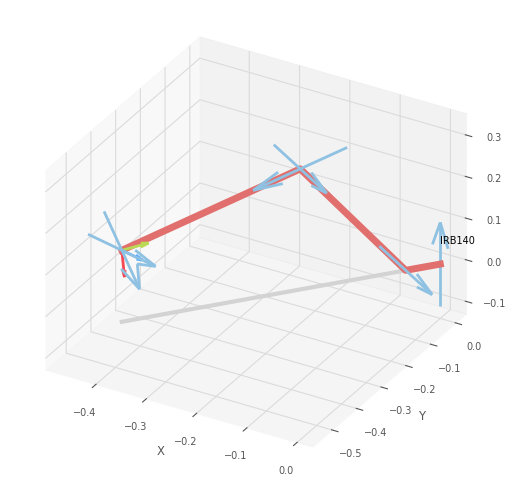

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'IRB140')

<Figure size 640x480 with 0 Axes>

In [20]:
robot.plot(q)

Convergió correctamente
Error articular: [3.14152429 0.53774964 0.13832889 0.40089317 1.99935925 2.6153951 ]


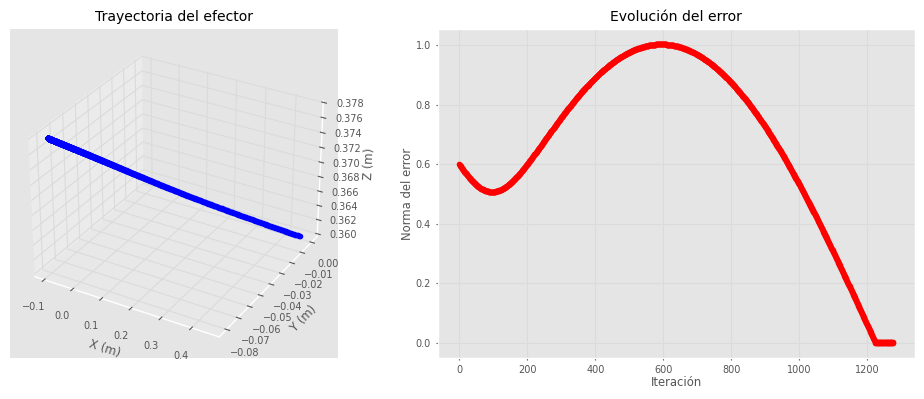

In [5]:
robot = irb140_clase()

q_original = np.random.uniform(-np.pi, np.pi, 6)
POSE_objetivo = robot.fkine(q_original)

q_sol, status, tray, errores = robot.ikine_recta_con_trayectoria(POSE_objetivo, q_inicial=np.zeros(6))
if status == 0:
    print("Convergió correctamente")
    error_final = np.abs(np.angle(np.exp(1j*(q_original - q_sol))))
    print("Error articular:", error_final)
else:
    print("No convergió")

fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(tray[:,0], tray[:,1], tray[:,2], 'b.-')
ax1.set_title("Trayectoria del efector")
ax1.set_xlabel("X (m)")
ax1.set_ylabel("Y (m)")
ax1.set_zlabel("Z (m)")

ax2 = fig.add_subplot(122)
ax2.plot(errores, 'r.-')
ax2.set_title("Evolución del error")
ax2.set_xlabel("Iteración")
ax2.set_ylabel("Norma del error")

plt.tight_layout()
plt.show()

In [7]:
robot.fkine(q_original), robot.fkine(q_sol)

(  -0.6232    0.6822    0.3823   -0.09351   
  -0.5004   -0.7235    0.4754   -0.08044   
   0.601     0.105     0.7923    0.3778    
   0         0         0         1         
,
   -0.623     0.6824    0.3823   -0.0935    
  -0.5008   -0.7234    0.4752   -0.08044   
   0.6009    0.1046    0.7925    0.3778    
   0         0         0         1         
)

In [57]:
print(robot.links[2].offset)

3.141592653589793
